# import

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns 
import re
from datetime import datetime
from functools import reduce
%matplotlib inline

# Загружаем специальный удобный инструмент для разделения датасета:
from sklearn.model_selection import train_test_split

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/sf-dst-restaurant-rating/kaggle_task.csv
/kaggle/input/sf-dst-restaurant-rating/main_task.csv
/kaggle/input/sf-dst-restaurant-rating/sample_submission.csv


In [2]:
# фиксируйте RANDOM_SEED, чтобы эксперименты были воспроизводимы
RANDOM_SEED = 42

# зафиксируем версию пакетов, чтобы эксперименты были воспроизводимы
!pip freeze > requirements.txt

# DATA

In [3]:
DATA_DIR = '/kaggle/input/sf-dst-restaurant-rating/'
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'kaggle_task.csv')
sample_submission = pd.read_csv(DATA_DIR+'/sample_submission.csv')

In [4]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      40000 non-null  object 
 1   City               40000 non-null  object 
 2   Cuisine Style      30717 non-null  object 
 3   Ranking            40000 non-null  float64
 4   Rating             40000 non-null  float64
 5   Price Range        26114 non-null  object 
 6   Number of Reviews  37457 non-null  float64
 7   Reviews            40000 non-null  object 
 8   URL_TA             40000 non-null  object 
 9   ID_TA              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB


In [5]:
df_train.head()

,Restaurant_id,City,Cuisine Style,Ranking,Rating,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


In [6]:
df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      10000 non-null  object 
 1   City               10000 non-null  object 
 2   Cuisine Style      7693 non-null   object 
 3   Ranking            10000 non-null  float64
 4   Price Range        6525 non-null   object 
 5   Number of Reviews  9343 non-null   float64
 6   Reviews            9998 non-null   object 
 7   URL_TA             10000 non-null  object 
 8   ID_TA              10000 non-null  object 
dtypes: float64(2), object(7)
memory usage: 703.2+ KB


In [7]:
df_test.head()

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA
0,id_0,Paris,"['Bar', 'Pub']",12963.0,$$ - $$$,4.0,"[[], []]",/Restaurant_Review-g187147-d10746918-Reviews-L...,d10746918
1,id_1,Helsinki,"['European', 'Scandinavian', 'Gluten Free Opti...",106.0,$$ - $$$,97.0,"[['Very good reviews!', 'Fine dining in Hakani...",/Restaurant_Review-g189934-d6674944-Reviews-Ra...,d6674944
2,id_2,Edinburgh,['Vegetarian Friendly'],810.0,$$ - $$$,28.0,"[['Better than the Links', 'Ivy Black'], ['12/...",/Restaurant_Review-g186525-d13129638-Reviews-B...,d13129638
3,id_3,London,"['Italian', 'Mediterranean', 'European', 'Vege...",1669.0,$$$$,202.0,"[['Most exquisite', 'Delicious and authentic']...",/Restaurant_Review-g186338-d680417-Reviews-Qui...,d680417
4,id_4,Bratislava,"['Italian', 'Mediterranean', 'European', 'Seaf...",37.0,$$$$,162.0,"[['Always the best in bratislava', 'Very good ...",/Restaurant_Review-g274924-d1112354-Reviews-Ma...,d1112354


In [8]:
sample_submission.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Restaurant_id  10000 non-null  object 
 1   Rating         10000 non-null  float64
dtypes: float64(1), object(1)
memory usage: 156.4+ KB


In [9]:
sample_submission.head()

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0


In [10]:
#Для корректной обработки признаков объединяем трейн и тест в один датасет
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.2+ MB


Подробнее по признакам:

* City: Город
* Cuisine Style: Кухня
* Ranking: Ранг ресторана относительно других ресторанов в этом городе
* Price Range: Цены в ресторане в 3 категориях
* Number of Reviews: Количество отзывов
* Reviews: 2 последних отзыва и даты этих отзывов
* URL_TA: страница ресторана на 'www.tripadvisor.com'
* ID_TA: ID ресторана в TripAdvisor
* Rating: Рейтинг ресторана

In [11]:
data.sample(10)

,Restaurant_id,City,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating
24155,id_9562,London,"['European', 'Turkish', 'Grill', 'Romanian']",9571.0,$$ - $$$,3.0,"[['Lovely atmosphere and surroundings', '30th ...",/Restaurant_Review-g186338-d11488906-Reviews-M...,d11488906,1,4.5
3430,id_3430,Amsterdam,NaN,2294.0,NaN,9.0,"[['Quick Pint', 'off the beaten track ..'], ['...",/Restaurant_Review-g188590-d8510349-Reviews-Ca...,d8510349,0,0.0
6336,id_6336,Paris,"['French', 'Cafe', 'European', 'Vegetarian Fri...",3450.0,$$ - $$$,497.0,"[['Nice and friendly staff', 'Outside Cafe for...",/Restaurant_Review-g187147-d3197704-Reviews-Bi...,d3197704,0,0.0
29322,id_4080,Barcelona,"['Peruvian', 'South American']",4081.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187497-d10338097-Reviews-O...,d10338097,1,5.0
21033,id_1724,Prague,['Pub'],1727.0,$$ - $$$,9.0,"[['Asian restaurant', 'Not longer a pizzeria b...",/Restaurant_Review-g274707-d5048725-Reviews-U_...,d5048725,1,4.5
34250,id_7156,London,"['Moroccan', 'Fast Food', 'Mediterranean', 'Gr...",7165.0,$,7.0,"[['Genuine, unaffected, Moroccan eatery', 'Del...",/Restaurant_Review-g186338-d10758793-Reviews-M...,d10758793,1,5.0
40475,id_11582,Paris,['Chinese'],11584.0,$$ - $$$,12.0,"[['Good neighborhood restaurant'], ['12/22/201...",/Restaurant_Review-g187147-d858380-Reviews-Au_...,d858380,1,4.0
2659,id_2659,Munich,"['Italian', 'Mediterranean', 'European', 'Pizz...",505.0,$$ - $$$,55.0,"[['Good place for the price', 'Cozy place, goo...",/Restaurant_Review-g187309-d6984545-Reviews-O_...,d6984545,0,0.0
14882,id_8734,Madrid,['French'],8742.0,NaN,NaN,"[[], []]",/Restaurant_Review-g187514-d2717760-Reviews-De...,d2717760,1,1.0
12753,id_7723,Madrid,['Steakhouse'],7730.0,$$ - $$$,36.0,"[['Long wait not worth it.', 'Bad experience.'...",/Restaurant_Review-g187514-d5487054-Reviews-Fo...,d5487054,1,2.5


In [12]:
# Необходимо обработать данные
data = data.drop_duplicates()
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Restaurant_id      50000 non-null  object 
 1   City               50000 non-null  object 
 2   Cuisine Style      38410 non-null  object 
 3   Ranking            50000 non-null  float64
 4   Price Range        32639 non-null  object 
 5   Number of Reviews  46800 non-null  float64
 6   Reviews            49998 non-null  object 
 7   URL_TA             50000 non-null  object 
 8   ID_TA              50000 non-null  object 
 9   sample             50000 non-null  int64  
 10  Rating             50000 non-null  float64
dtypes: float64(3), int64(1), object(7)
memory usage: 4.6+ MB


In [13]:
data.nunique()

Restaurant_id        13094
City                    31
Cuisine Style        10731
Ranking              12975
Price Range              3
Number of Reviews     1573
Reviews              41857
URL_TA               49963
ID_TA                49963
sample                   2
Rating                  10
dtype: int64

In [14]:
# Рассмотрим вначале признаки City и Price Range
# Так как поле City содержит небольшое количество уникальных значений, можно добавить dummies переменные
data = pd.get_dummies(data, columns=[ 'City',], dummy_na=True)

# Поле Price Range содержит всего 3 уникальных значения. Данный признак можно преобразовать к численному виду
dict_price = {'$$$$': 3,'$$ - $$$': 2,'$': 1}
data['Price Range'] = data['Price Range'].replace(to_replace=dict_price).fillna(0)

data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oporto,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan
1197,id_1197,['Italian'],3820.0,0.0,4.0,"[[], []]",/Restaurant_Review-g187849-d3791808-Reviews-Th...,d3791808,0,0.0,...,0,0,0,0,0,0,0,0,0,0
33069,id_2430,"['Spanish', 'Seafood', 'Mediterranean', 'Europ...",2431.0,2.0,252.0,"[['Paella with lobster. Good looking', 'Good']...",/Restaurant_Review-g187497-d781598-Reviews-La_...,d781598,1,3.5,...,0,0,0,0,0,0,0,0,0,0
46635,id_1918,NaN,1919.0,0.0,15.0,"[['Wonderful food, friendly service', 'Very ni...",/Restaurant_Review-g188644-d9729591-Reviews-Dy...,d9729591,1,3.5,...,0,0,0,0,0,0,0,0,0,0
16055,id_751,"['German', 'Austrian', 'Bar', 'Central Europea...",752.0,2.0,145.0,"[['The famous Heuriger !!', 'Nice Winery resta...",/Restaurant_Review-g190454-d1104466-Reviews-Al...,d1104466,1,3.5,...,0,0,0,0,0,0,1,0,0,0
23487,id_6866,['Pizza'],6867.0,0.0,NaN,"[[], []]",/Restaurant_Review-g187497-d7691348-Reviews-Re...,d7691348,1,3.0,...,0,0,0,0,0,0,0,0,0,0


In [15]:
# Рассмотрим признак "Cuisine Style" и создадим новый признак, показывающий количество типов кухни в ресторане
# Если в поле нет данных, установим значение 1, так как хотя бы одна кухня точно присутствует в ресторане
data['Cuis_style_count'] = data['Cuisine Style'].fillna('net_dannyh')
data['Cuis_style_count'] = data['Cuis_style_count'].apply(lambda x: len(re.sub(r"[\[, \], ']", " ", x).strip().split()))

data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Oslo,City_Paris,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Cuis_style_count
7219,id_7219,"['Japanese', 'Asian', 'Soups', 'Vegetarian Fri...",417.0,2.0,38.0,"[['Souless Ramen', 'Poor service , impolite, n...",/Restaurant_Review-g190356-d5775023-Reviews-Ra...,d5775023,0,0.0,...,0,0,0,0,0,0,0,0,0,5
32655,id_1842,"['Healthy', 'Vegetarian Friendly', 'Vegan Opti...",1844.0,0.0,3.0,"[['Homemade goodness !'], ['05/13/2014']]",/Restaurant_Review-g190454-d6210623-Reviews-Ra...,d6210623,1,5.0,...,0,0,0,0,0,1,0,0,0,5
30834,id_13599,"['Fast Food', 'American']",13609.0,1.0,56.0,"[['usual taste', 'Very busy'], ['12/31/2017', ...",/Restaurant_Review-g186338-d4131570-Reviews-Mc...,d4131570,1,3.5,...,0,0,0,0,0,0,0,0,0,3
22736,id_952,"['American', 'Bar', 'Pub']",953.0,2.0,66.0,"[['Average sports bar fare', 'Lunch at Forum']...",/Restaurant_Review-g189934-d6550876-Reviews-O_...,d6550876,1,3.5,...,0,0,0,0,0,0,0,0,0,3
46026,id_736,"['Italian', 'Bar', 'Cafe', 'Mediterranean', 'V...",737.0,1.0,173.0,"[['Authentic Roman food and such nice staff!',...",/Restaurant_Review-g187791-d4109184-Reviews-Ba...,d4109184,1,4.5,...,0,0,0,1,0,0,0,0,0,6


In [16]:
# Далее рассмотрим признак Number of Reviews и заполним NaN значения нулями
data['Number of Reviews'] = data['Number of Reviews'].fillna(0)

# Осталось преобразовать признак Reviews
# Создадим новый признак, показывающий разница в днях последних двух комментариев. В противном случае 0
data['Reviews_razn'] = data['Reviews'].apply(lambda x: re.findall(r'\d{2}/\d{2}/\d{4}', str(x)))
data['Reviews_razn'] = data['Reviews_razn'].apply(
    lambda x: reduce(lambda a,b : (datetime.strptime(a,'%m/%d/%Y') - datetime.strptime(b,'%m/%d/%Y')).days, x)
    if len(x)==2 else 0).astype(int)

# Создадим новый признак, показывающий отношение Ranking на Number of Reviews
data['Ranking_by_rev'] = round(data['Ranking'] / data['Number of Reviews'], 2)

data.sample(5)

,Restaurant_id,Cuisine Style,Ranking,Price Range,Number of Reviews,Reviews,URL_TA,ID_TA,sample,Rating,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Cuis_style_count,Reviews_razn,Ranking_by_rev
30786,id_93,"['Italian', 'Pizza', 'Mediterranean', 'Europea...",94.0,2.0,366.0,"[['Gluten free pizza', 'Amazing Italian restau...",/Restaurant_Review-g190454-d2516528-Reviews-Pi...,d2516528,1,4.5,...,0,0,0,1,0,0,0,11,2,0.26
22135,id_7729,['Japanese'],7730.0,2.0,32.0,"[[""Miyako rue d'Avron is yummy"", 'Excellent se...",/Restaurant_Review-g187147-d783834-Reviews-Miy...,d783834,1,4.0,...,0,0,0,0,0,0,0,1,40,241.56
29603,id_1190,"['Peruvian', 'Spanish', 'Fusion', 'South Ameri...",1191.0,2.0,228.0,"[['Exceptional value for money', 'Wonderful Ga...",/Restaurant_Review-g187514-d2718737-Reviews-Mi...,d2718737,1,4.5,...,0,0,0,0,0,0,0,5,27,5.22
19004,id_1259,"['Mexican', 'American']",1260.0,0.0,4.0,"[['Great burgers', 'Great place, great food.']...",/Restaurant_Review-g274887-d10744459-Reviews-M...,d10744459,1,5.0,...,0,0,0,0,0,0,0,2,461,315.00
34970,id_1693,NaN,1695.0,0.0,15.0,"[['Two different opinions', 'Greek meze bar'],...",/Restaurant_Review-g189400-d1067533-Reviews-To...,d1067533,1,3.0,...,0,0,0,0,0,0,0,1,416,113.00


# Data Preprocessing

In [17]:
df_train = pd.read_csv(DATA_DIR+'/main_task.csv')
df_test = pd.read_csv(DATA_DIR+'/kaggle_task.csv')
df_train['sample'] = 1 # помечаем где у нас трейн
df_test['sample'] = 0 # помечаем где у нас тест
df_test['Rating'] = 0 # в тесте у нас нет значения Rating, мы его должны предсказать, по этому пока просто заполняем нулями

data = df_test.append(df_train, sort=False).reset_index(drop=True) # объединяем

In [18]:
def preproc_data(df_input):
    
    df_output = df_input.copy()
    
    # Предобработка данных
    df_output = df_output.drop_duplicates()
    df_output.drop(['Restaurant_id','ID_TA',], axis = 1, inplace=True)
    
    # Заполнение NaN значений.
    df_output['Number of Reviews'] = df_output['Number of Reviews'].fillna(0)
    df_output['Cuisine Style'] = df_output['Cuisine Style'].fillna('net_dannyh')
    df_output['Price Range'] = df_output['Price Range'].fillna(0)
    
    #Создаем dummies признаки
    df_output = pd.get_dummies(df_output, columns=[ 'City',], dummy_na=True)
    
    # Feature Engineering
    # 1. "Price Range"
    dict_price = {'$$$$': 3,'$$ - $$$': 2,'$': 1}
    df_output['Price Range'] = df_output['Price Range'].replace(to_replace=dict_price).fillna(0)
    
    # 2. "Cuisine Style count"
    df_output['Cuis_style_count'] = df_output['Cuisine Style'].apply(lambda x: len(re.sub(r"[\[, \], ']", " ", x).strip().split()))
    
    # 3. "Reviews difference days"
    df_output['Reviews_razn'] = df_output['Reviews'].apply(lambda x: re.findall(r'\d{2}/\d{2}/\d{4}', str(x)))
    df_output['Reviews_razn'] = df_output['Reviews_razn'].apply(
        lambda x: reduce(lambda a,b : (datetime.strptime(a,'%m/%d/%Y') - datetime.strptime(b,'%m/%d/%Y')).days, x)
        if len(x)==2 else 0).astype(int)
    
    # 4. "Ranking by Reviews"
    df_output['Ranking_by_rev'] = round(df_output['Ranking'] / data['Number of Reviews'], 2).fillna(0)
    
    # Убираем ненужные признаки
    object_columns = [s for s in df_output.columns if df_output[s].dtypes == 'object']
    df_output.drop(object_columns, axis = 1, inplace=True)
    
    return df_output

In [19]:
df_preproc = preproc_data(data)
df_preproc.sample(10)

,Ranking,Price Range,Number of Reviews,sample,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Cuis_style_count,Reviews_razn,Ranking_by_rev
17591,8294.0,0,0.0,1,5.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.00
37170,2898.0,0,0.0,1,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0.00
49009,146.0,0,7.0,1,5.0,0,0,0,0,1,...,0,0,0,0,0,0,0,4,4,20.86
28097,869.0,0,3.0,1,4.5,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,289.67
33511,1394.0,1,88.0,1,4.0,0,0,0,0,0,...,0,0,0,0,0,0,0,7,143,15.84
20475,2036.0,2,37.0,1,2.5,0,0,0,0,0,...,0,0,0,0,1,0,0,1,15,55.03
9664,1142.0,2,312.0,0,0.0,0,0,0,0,0,...,0,0,0,0,0,0,0,6,0,3.66
15520,1573.0,1,20.0,1,3.5,0,1,0,0,0,...,0,0,0,0,0,0,0,1,192,78.65
5445,3884.0,0,6.0,0,0.0,0,0,0,0,0,...,1,0,0,0,0,0,0,3,0,647.33
46726,70.0,3,666.0,1,4.5,0,0,0,0,0,...,1,0,0,0,0,0,0,8,17,0.11


In [20]:
df_preproc.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50000 entries, 0 to 49999
Data columns (total 40 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Ranking            50000 non-null  float64
 1   Price Range        50000 non-null  int64  
 2   Number of Reviews  50000 non-null  float64
 3   sample             50000 non-null  int64  
 4   Rating             50000 non-null  float64
 5   City_Amsterdam     50000 non-null  uint8  
 6   City_Athens        50000 non-null  uint8  
 7   City_Barcelona     50000 non-null  uint8  
 8   City_Berlin        50000 non-null  uint8  
 9   City_Bratislava    50000 non-null  uint8  
 10  City_Brussels      50000 non-null  uint8  
 11  City_Budapest      50000 non-null  uint8  
 12  City_Copenhagen    50000 non-null  uint8  
 13  City_Dublin        50000 non-null  uint8  
 14  City_Edinburgh     50000 non-null  uint8  
 15  City_Geneva        50000 non-null  uint8  
 16  City_Hamburg       500

In [21]:
# Теперь выделим тестовую часть
train_data = df_preproc.query('sample == 1').drop(['sample'], axis=1)
test_data = df_preproc.query('sample == 0').drop(['sample'], axis=1)

y = train_data.Rating.values
X = train_data.drop(['Rating'], axis=1)


Перед тем как отправлять наши данные на обучение, разделим данные на еще один тест и трейн, для валидации. Это поможет нам проверить, как хорошо наша модель работает, до отправки submissiona на kaggle.

In [22]:
# Воспользуемся специальной функцие train_test_split для разбивки тестовых данных
# выделим 20% данных на валидацию (параметр test_size)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_SEED)

In [23]:
# проверяем
test_data.shape, train_data.shape, X.shape, X_train.shape, X_test.shape

((10000, 39), (40000, 39), (40000, 38), (32000, 38), (8000, 38))

# Model

In [24]:
# Импортируем необходимые библиотеки:
from sklearn.ensemble import RandomForestRegressor # инструмент для создания и обучения модели
from sklearn import metrics # инструменты для оценки точности модели

In [25]:
# Создаём модель (НАСТРОЙКИ НЕ ТРОГАЕМ)
model = RandomForestRegressor(n_estimators=100, verbose=1, n_jobs=-1, random_state=RANDOM_SEED)

In [26]:
# Обучаем модель на тестовом наборе данных
model.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = model.predict(X_test)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 tasks      | elapsed:    3.0s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    7.0s finished
[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.0s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.1s finished


In [27]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.209595


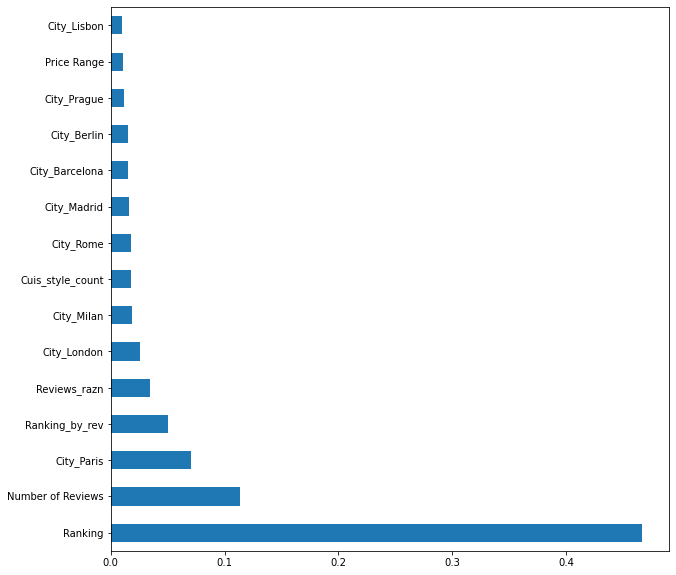

In [28]:
# в RandomForestRegressor есть возможность вывести самые важные признаки для модели
plt.rcParams['figure.figsize'] = (10,10)
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(15).plot(kind='barh')

# Submission

In [29]:
test_data.sample(10)

,Ranking,Price Range,Number of Reviews,Rating,City_Amsterdam,City_Athens,City_Barcelona,City_Berlin,City_Bratislava,City_Brussels,...,City_Prague,City_Rome,City_Stockholm,City_Vienna,City_Warsaw,City_Zurich,City_nan,Cuis_style_count,Reviews_razn,Ranking_by_rev
4990,3501.0,1,15.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,43,233.40
6258,11046.0,0,14.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,-10,789.00
9841,871.0,2,713.0,0.0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,12,20,1.22
6476,315.0,1,20.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,-234,15.75
1544,3524.0,1,57.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,1,0,61.82
9116,354.0,1,39.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,10,9.08
4812,1808.0,1,336.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,9,2,5.38
6433,1633.0,2,117.0,0.0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,2,0,13.96
1763,1380.0,0,23.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,3,0,60.00
514,1089.0,0,3.0,0.0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,363.00


In [30]:
test_data = test_data.drop(['Rating'], axis=1)

In [31]:
sample_submission

,Restaurant_id,Rating
0,id_0,2.0
1,id_1,2.5
2,id_2,4.0
3,id_3,1.0
4,id_4,4.0
...,...,...
9995,id_9995,3.0
9996,id_9996,1.5
9997,id_9997,4.5
9998,id_9998,1.0


In [32]:
predict_submission = model.predict(test_data)

[Parallel(n_jobs=4)]: Using backend ThreadingBackend with 4 concurrent workers.
[Parallel(n_jobs=4)]: Done  42 tasks      | elapsed:    0.1s
[Parallel(n_jobs=4)]: Done 100 out of 100 | elapsed:    0.2s finished


In [33]:
predict_submission

array([3.075, 4.325, 4.45 , ..., 3.02 , 4.495, 4.205])

In [34]:
sample_submission['Rating'] = predict_submission
sample_submission.to_csv('submission.csv', index=False)
sample_submission.head(10)

,Restaurant_id,Rating
0,id_0,3.075
1,id_1,4.325
2,id_2,4.450
3,id_3,4.295
4,id_4,4.470
5,id_5,4.475
6,id_6,2.410
7,id_7,2.730
8,id_8,4.185
9,id_9,4.730
